<a href="https://colab.research.google.com/github/justinsydnor/GB894/blob/main/GB894_Autodata_HW3start.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of autodata for GB 894 Homework 3
Case study for General Business 894

Created by Professor Justin Sydnor

Last edited 5/24/2025

## Overview
This notebook gets you started with Homework 3. We load in the auto dataset from our github repo. We then get a start at fitting a logistic regression and calculating fairness and accuracy measures.

The key next step is to repeat the analysis but with a different set of features.

# Loading in the data

We start by loading in packages (there are more loading here than we will really need).

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve


Next we load in the data from our github repo.

In [2]:
# Load in the auto data

url = "https://raw.githubusercontent.com/justinsydnor/GB894/refs/heads/main/autodata.csv"

df = pd.read_csv(url)
print(df.head())


   policyno    plcydate  clm_freq5  clm_amt5  clm_amt  kidsdriv  travtime  \
0       160  1997-11-08          2      4461        0         0        14   
1     24836  1998-07-29          0         0        0         0        22   
2     28046  1995-10-28          0         0        0         0        26   
3     28960  1994-06-11          2     38690        0         0         5   
4     40933  1993-09-20          0         0        0         0        32   

      car_use  bluebook  retained  ...  cartype_van redcar revolked  male  \
0     Private     14230        11  ...            0      1        0     1   
1  Commercial     14940         1  ...            0      1        0     1   
2     Private     21970         1  ...            1      1        0     1   
3     Private      4010         4  ...            0      0        0     0   
4     Private     15440         7  ...            0      1        0     1   

  married  singleparent  job_bluecollar  urban  homeowner probclaim  
0   

### Limit to variables we want to use for this assignment
To simplify our modeling and avoid some complications with missing data elements, we will limit our data set to a core set of variables. Recall that the homework page in Canvas gives you links to variable definitions.

In [3]:
# Update the data frame to keep on the variables hadclaim commercial clm_freq5 clm_amt5 kidsdriv travtime redcar bluebook retained revolked mvr_pts age homekids male married urban homeowner yearsinhome job_bluecollar probclaim

df = df[['hadclaim', 'commercial', 'clm_freq5', 'clm_amt5', 'kidsdriv', 'travtime', 'redcar', 'bluebook', 'retained', 'revolked', 'mvr_pts', 'age', 'homekids', 'male', 'married', 'urban', 'homeowner', 'yearsinhome', 'job_bluecollar', 'probclaim']]
print(df.head())

   hadclaim  commercial  clm_freq5  clm_amt5  kidsdriv  travtime  redcar  \
0         0           0          2      4461         0        14       1   
1         0           1          0         0         0        22       1   
2         0           0          0         0         0        26       1   
3         0           0          2     38690         0         5       0   
4         0           0          0         0         0        32       1   

   bluebook  retained  revolked  mvr_pts  age  homekids  male  married  urban  \
0     14230        11         0        3   60         0     1        0      1   
1     14940         1         0        0   43         0     1        0      1   
2     21970         1         0        2   48         0     1        0      1   
3      4010         4         0        3   35         1     0        1      1   
4     15440         7         0        0   51         0     1        1      1   

   homeowner  yearsinhome  job_bluecollar  probclaim  
0

We can create a quick table to look at the mean of each of these variables so we understand the data better.

In [4]:
# create a table of the average values of the variables in the df

# Calculate the mean of each numeric column
average_values = df.mean(numeric_only=True)

# Convert the Series to a DataFrame for better display as a table
average_values_table = pd.DataFrame(average_values, columns=['Average Value'])

average_values_table

,Average Value
hadclaim,0.265534
commercial,0.370754
clm_freq5,0.800435
clm_amt5,4034.417046
kidsdriv,0.167150
travtime,33.462925
redcar,0.288422
bluebook,15676.792668
retained,5.336268
revolked,0.122618


### Split into test and train data sets

In [5]:
train, test = train_test_split(df, test_size=0.25, random_state=32)

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (7242, 20)
Test shape: (2414, 20)


We can extract our X and y, where from X we exclude the outcome we are trying to predict (hadclaim), our sensitive group lable 'job_bluecollar', and the 'probclaim' model prediction probability that we received with this data in the prior homework. We will create new probability models here.

In [6]:
X=train.drop(['hadclaim', 'job_bluecollar', 'probclaim'], axis=1)
y=train['hadclaim']

Xtest=test.drop(['hadclaim', 'job_bluecollar' ,'probclaim'], axis=1)
ytest=test['hadclaim']

## Logit Regression on the full set of features
We begin by estimating a logit model predicting having a claim on all of the available features.

In [7]:
# prompt: Create a logistic regression of y on the X

# Add a constant to the predictor variables
X = sm.add_constant(X)

# Create and fit the logistic regression model
logit_mod_full = sm.Logit(y, X).fit()

# Print the summary of the model
print(logit_mod_full.summary())

Optimization terminated successfully.
         Current function value: 0.460054
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               hadclaim   No. Observations:                 7242
Model:                          Logit   Df Residuals:                     7224
Method:                           MLE   Df Model:                           17
Date:                Sat, 24 May 2025   Pseudo R-squ.:                  0.2066
Time:                        08:34:41   Log-Likelihood:                -3331.7
converged:                       True   LL-Null:                       -4199.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -2.6098      0.242    -10.789      0.000      -3.084      -2.136
commercial      0.9404    

You might take a little time at this point to look over the set of coefficient estimates and form some initial hypotheses as to why some of these variables enter the model with the strength and/or direction they do.

Next we get the predicted probabilities. We will label everything here with the subscript "full" to reflect the full-feature logit model.

In [8]:
# prompt: get the predicted probabilities from the logit_mod_full in the dataset test separately by the variable job_bluecollar

# Add a constant to the test predictor variables
Xtest = sm.add_constant(Xtest)

# Get the predicted probabilities for the test set
test['prob_full'] = logit_mod_full.predict(Xtest)

Now we get the predicted classifications based on our pre-determined threshold of probability > .6.

In [20]:
# Create a binary prediction of 1 if the predicted probability is greater than .6 and 0 otherwise.
test['predicted_full'] = np.where(test['prob_full'] > 0.6, 1, 0)

# Create a table with average prediction and average actual claim rate.
prediction_summary = test[['predicted_full', 'hadclaim']].mean().round(3)
prediction_summary



,0
predicted_full,0.089
hadclaim,0.262


We see that the model only was able to predict about 9% at risk even though th 26% of the sample had a claim. This is related to the 60% threshold in probability we used to classify.

We can also add the confusion matrix at this point

In [16]:
# Let's get the confusion matrix
cm_temp_full = confusion_matrix(ytest, test['predicted_full'])

# Wrap it in a labeled DataFrame
cm_full = pd.DataFrame(
    cm_temp_full,
    index=['Actual 0', 'Actual 1'],
    columns=['Predicted 0', 'Predicted 1']
)

print("Confusion Matrix:")
cm_full

Confusion Matrix:


,Predicted 0,Predicted 1
Actual 0,1712,69
Actual 1,487,146


We see that the full logit model correctly predicted 146 of 633 actual positive cases in the test set.

### Analyze differences in the predictions
Now we want to graph the distribution of the predicted probabilities separately by our group variable for blue collar vs. not.

In [21]:
# Create a table with average prediction and average actual claim rate by blue collar status.
prediction_summary = test.groupby('job_bluecollar')[['predicted_full', 'hadclaim']].mean().round(3)
prediction_summary


,predicted_full,hadclaim
job_bluecollar,,
0,0.067,0.234
1,0.169,0.364


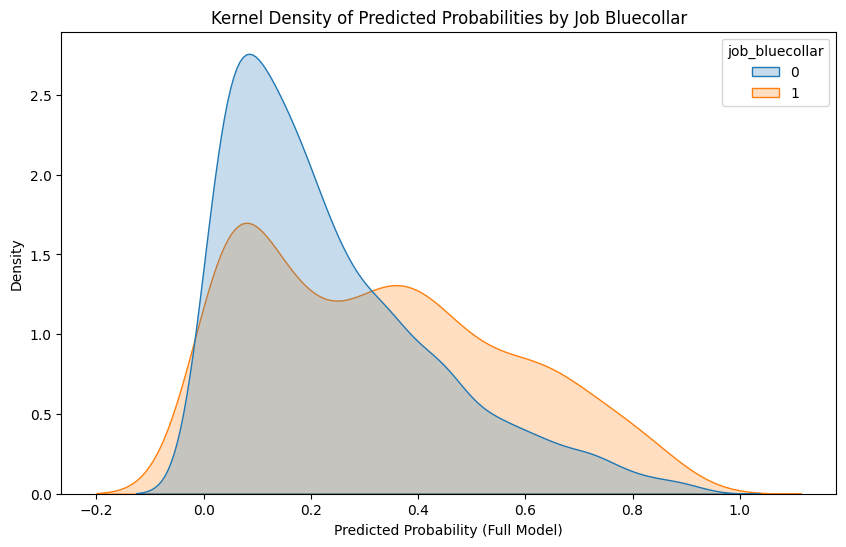

In [22]:
# prompt: graph the kernel density of the predicted probabilities by job_bluecollar

# Graph the kernel density of the predicted probabilities by job_bluecollar
plt.figure(figsize=(10, 6))
# Create the plot and use the common_norm=False option so that it gets densities by group
sns.kdeplot(data=test, x='prob_full', hue='job_bluecollar', fill=True, common_norm=False)
plt.title('Kernel Density of Predicted Probabilities by Job Bluecollar')
plt.xlabel('Predicted Probability (Full Model)')
plt.ylabel('Density')
plt.show()

We can see in this graph and the table above it that the blue collar workers are getting more predictions in the higher range above 0.4, while the non-blue collar workers get predictions from the model that are more tightly centered in the range below 0.2. We see then that on a simple measure of the rate at which groups are predicted high risk that the model predictions are "unfair" across blue-collar and non-blue-collar workers.

### Accuracy measures
Now we want to know how accurate the model predictions were. We can consider a few different metrics. First, accuracy is just the share of correct predictions. Then we can also do the area under the receiver operating curve AUC. Finally, we can get the average predicsion score. This measure is useful when we have imbalanced data where the outcome is somewhat rare.

The Average Precision Score is a summary metric for the Precision-Recall (PR) curve. It captures how well a classifier identifies positive cases across different probability thresholds.

Precision = How many of the predicted positives are truly positive

Recall = How many of the actual positives were correctly identified

APS is the area under the Precision-Recall curve.

In [32]:
# prompt: Create a measure of the overall accuracy of the predictions where accuracy is defined as the share of correct predictions of hadclaim. Create a measure of the fairness of the predictions that is defined as the difference between the average share of positive predictions for job_bluecollar = 1 minus the average share of positive predictions for job_bluecollar = 0

# Overall accuracy
accuracy_full = (test['predicted_full'] == test['hadclaim']).mean()
print(f"Accuracy_full model: {accuracy_full:.3f}")

# Calculate AUC
auc_full = roc_auc_score(test['hadclaim'], test['prob_full'])
print(f"AUC (Full model): {auc_full:.3f}")

# Calculate Average Precision Score
aps_full = average_precision_score(test['hadclaim'], test['prob_full'])
print(f"Average Precision Score (Full model): {aps_full:.3f}")

Accuracy_full model: 0.770
AUC (Full model): 0.779
Average Precision Score (Full model): 0.554


So we see an accuracy score of about 77%. That might sound good but note that with the actual claim rate of 26%, we'd get 74% accuracy even if we just predicted 0 for everyone. The average predicision scrore may be more diagnostic here.

### Fairness measure
Here for fairness we will use the difference in the share predicted positive for blue collar vs. non-blue-collar workers. We take the negative of that differences so that an increase means a reduction in the excess predictions for blue-collar vs non-blue-collar workers.

In [31]:
# Fairness measure
fairness_full = -(prediction_summary.loc[1, 'predicted_full'] - prediction_summary.loc[0, 'predicted_full'])
print(f"Fairness measure -(share of positive predictions for blue collar - share for non-blue collar): {fairness_full:.3f}")

Fairness measure -(share of positive predictions for blue collar - share for non-blue collar): -0.102


## Compare to a stripped down model
Now let's consider how different the model predictions would be if we used a very reduced model that only predicted based on past claim variables (in this case clm_freq5 and clm_amt5). After we do this step we can compare accuracy and fairness measures between models in a plot.

### Rerun the code reducting the variables
Call this model "onlyclaims"

Optimization terminated successfully.
         Current function value: 0.553811
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               hadclaim   No. Observations:                 7242
Model:                          Logit   Df Residuals:                     7239
Method:                           MLE   Df Model:                            2
Date:                Sat, 24 May 2025   Pseudo R-squ.:                 0.04497
Time:                        09:02:22   Log-Likelihood:                -4010.7
converged:                       True   LL-Null:                       -4199.5
Covariance Type:            nonrobust   LLR p-value:                 9.664e-83
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4173      0.036    -39.512      0.000      -1.488      -1.347
clm_freq5      0.3814      0.

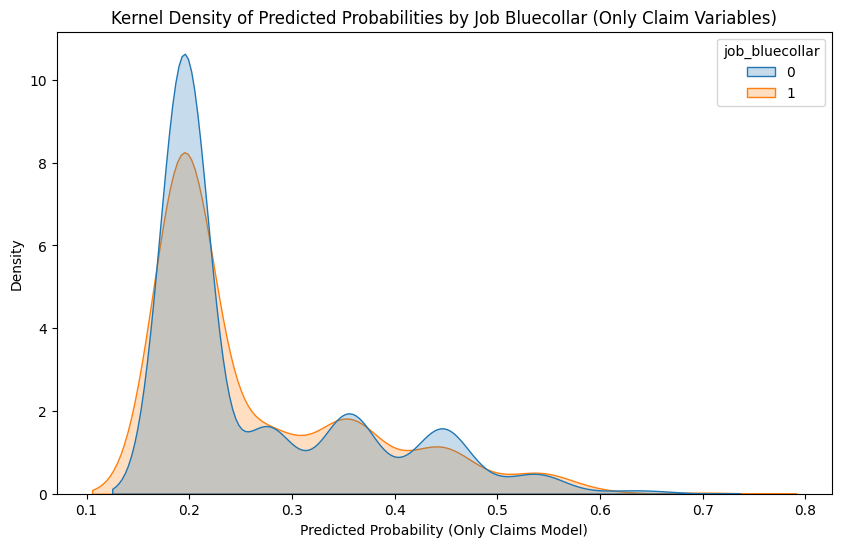

                predicted_onlyclaims  hadclaim
job_bluecollar                                
0                           0.006342  0.234144
1                           0.003831  0.363985
Accuracy_onlyclaims model: 0.738
AUC (Only Claim Variables model): 0.629
Average Precision Score (Full model): 0.554
Fairness measure (Only Claim Variables model): 0.003


In [28]:
#from sklearn.metrics import roc_auc_score
#import statsmodels.api as sm
#import matplotlib.pyplot as plt
#import seaborn as sns
#import numpy as np

# Define the variables to keep
keep_vars_features = ['clm_freq5', 'clm_amt5']

# Select only those features from train and test sets
X_onlyclaims = train[keep_vars_features]
Xtest_onlyclaims = test[keep_vars_features]

# Add a constant to the predictor variables
X_onlyclaims = sm.add_constant(X_onlyclaims)
Xtest_onlyclaims = sm.add_constant(Xtest_onlyclaims)

# Create and fit the logistic regression model using only claim variables
logit_onlyclaims = sm.Logit(y, X_onlyclaims).fit()

# Print the summary of the logit_onlyclaims model
print(logit_onlyclaims.summary())

# Get the predicted probabilities for the test set using logit_onlyclaims
test['prob_onlyclaims'] = logit_onlyclaims.predict(Xtest_onlyclaims)

# Graph the kernel density of the predicted probabilities by job_bluecollar
plt.figure(figsize=(10, 6))
sns.kdeplot(data=test, x='prob_onlyclaims', hue='job_bluecollar', fill=True, common_norm=False)
plt.title('Kernel Density of Predicted Probabilities by Job Bluecollar (Only Claim Variables)')
plt.xlabel('Predicted Probability (Only Claims Model)')
plt.ylabel('Density')
plt.show()

# Create predicted outcomes based on a threshold (e.g., 0.6)
test['predicted_onlyclaims'] = np.where(test['prob_onlyclaims'] > 0.6, 1, 0)

# Create the summary table of predictions by job_bluecollar
prediction_summary_onlyclaims = test.groupby('job_bluecollar')[['predicted_onlyclaims', 'hadclaim']].mean()
print(prediction_summary_onlyclaims)

# Calculate overall accuracy for logit_onlyclaims
accuracy_onlyclaims = (test['predicted_onlyclaims'] == test['hadclaim']).mean()
print(f"Accuracy_onlyclaims model: {accuracy_onlyclaims:.3f}")

# Calculate AUC
auc_onlyclaims = roc_auc_score(test['hadclaim'], test['prob_onlyclaims'])
print(f"AUC (Only Claim Variables model): {auc_onlyclaims:.3f}")

# Calculate Average Precision Score
aps_onlyclaims = average_precision_score(test['hadclaim'], test['prob_onlyclaims'])
print(f"Average Precision Score (Full model): {aps_full:.3f}")

# Calculate fairness measure for logit_onlyclaims
fairness_onlyclaims = -(prediction_summary_onlyclaims.loc[1, 'predicted_onlyclaims'] - prediction_summary_onlyclaims.loc[0, 'predicted_onlyclaims'])
print(f"Fairness measure (Only Claim Variables model): {fairness_onlyclaims:.3f}")


We see in this very stripped down model that we end up generating almost no predicted values up over 60%. As a consequence, we predict almost no high-risk cases. This dramatically shrinks our measure of unfairness (of course). But it also reduces measures of model accuracy.

### Create a visualization of accuracy vs fairness
For this purpose I am going to create a graph that shows the AUC vs. the Fairness metric (difference in positive predicted rates). We could easily adapt this code to use Average Precision Score or accuracy instead -- I encourage you to consider that.

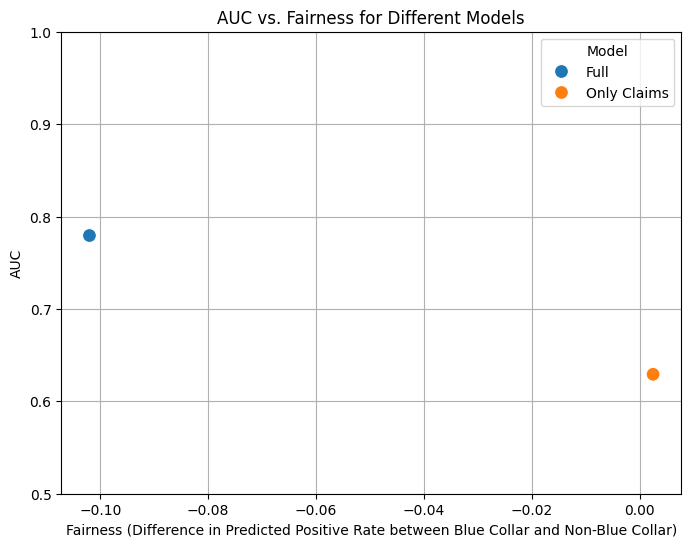

In [29]:
# prompt: Now create a plot that shows the accuracy measure on the y-axis and the fairness measure on the x-axis for each of the models full nocar and noage.

# Create a DataFrame to hold the results for plotting
results = pd.DataFrame({
    'Model': ['Full', 'Only Claims'],
    'Fairness': [fairness_full, fairness_onlyclaims],
    'AUC': [auc_full, auc_onlyclaims]
})

plt.figure(figsize=(8, 6))
sns.scatterplot(data=results, x='Fairness', y='AUC', hue='Model', s=100)

# Set y-axis range from .5 to 1
plt.ylim(.5, 1)

plt.title('AUC vs. Fairness for Different Models')
plt.xlabel('Fairness (Difference in Predicted Positive Rate between Blue Collar and Non-Blue Collar)')
plt.ylabel('AUC')
plt.grid(True)
plt.show()

So we can see here that going from the Full model to the Only Claims model removes concerns about fairness in the predictions (as measured by differentials in the positive predicted rate). But it also dramatically decreases the predictive power (as measured by AUC).

## Now it is your turn!
The task for this homework now that you have this start is to adapt the code to do some more models. I encourage you to use the code above where I reduced to the "Only Claims" model and adapt to name some other model candidates of your choosing. You should thoughtfully group together sets of predictors that have some meaning and interpretation or exclude certain predictors that you think are worth testing.

There is no maximum number of models you need to add, but the **minimum to add is 3 additional models**.